In [108]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.linear_model import LinearRegression

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Inputs will be:

 - Load [MW]
 - Wind Excess [MW]
 - Wind Shortage [MW]
 - Previous State of Charge [MWh]
 - Previous Tank Holdup [kg]
 - Next 4, 8, 12, 16, 24 Hrs Excess
 - Next 4, 8, 12, 16, 24 Hrs Shortage

Outputs will be:

 - Ratio Battery Input to Nameplate [MW]
 - Ratio PEM Input to Nameplate [MW]
 - Ratio Battery Output to Nameplate [MW]
 - Ratio Turbine Output to Nameplate[MW]

In [90]:
X, y = load_diabetes(return_X_y=True)
y = np.array([(r, r) for r in y])
X.shape, y.shape

reg2 = DecisionTreeRegressor(random_state=1, max_depth=5)

reg2.fit(X, y)

LinearRegression()

In [92]:
xt = X[:20]

pred2 = reg2.predict(xt)

In [106]:
import graphviz
graph = graphviz.Source(export_graphviz(reg2, filled=True), format='png')
graph.render("decision_tree_graphivz")

'decision_tree_graphivz.png'

In [121]:
import pandas as pd
import os
import json
from pathlib import Path
from dispatches.case_studies.renewables_h2_case.re_h2_parameters import re_h2_parameters, get_gen_outputs_from_rtsgmlc, kg_to_tons, h2_mols_per_kg


results_dir = Path("double_loop_317_CT_batth2")
with open(results_dir / "input_parameters.json", "r") as f:
    params = json.load(f)
year_results = pd.read_csv(results_dir / "design_timeseries_minsocfree.csv")
year_results.drop(columns="Unnamed: 0", inplace=True)
wind_gen = "317_WIND"
wind_gen_pmax = 799.1
gas_gen = "317_CT"
reserves = 15
shortfall = 500
start_date = '2020-01-01 00:00:00'
wind_cfs, wind_resource, loads_mw, wind_loads_mw = get_gen_outputs_from_rtsgmlc(wind_gen, gas_gen, reserves, shortfall, start_date)
loads_mw = loads_mw[0:len(year_results)]
year_results["Load [MW]"] = loads_mw
year_results["Wind Max [MW]"] = params['wind_mw'] * wind_cfs

In [122]:
print((year_results['Total Power Output [MW]'] - year_results['Load [MW]']).clip(upper=0).sum())
params['batt_mw'] = year_results['Battery Power Output [MW]'].max()
params['pem_mw'] = year_results['Wind Power to PEM [MW]'].max()
params['turb_mw'] = year_results['Turbine Power Output [MW]'].max()
year_results['Total Wind Generation [MW]'].max(), year_results['Battery Power Output [MW]'].max(), year_results['Turbine Power Output [MW]'].max(), year_results['Wind Power to PEM [MW]'].max()


-4.1744385725905886e-14


(929.8305543034136, 94.34833452736056, 45.98423635087665, 3.782219776052951)

In [123]:
import glob

columns = ["Design", "Wind MW", "Batt MW", "Batt MWh", "PEM MW", "Turb MW", "Tank Ton",
    "Capital Cost", "NPV",
    "Missed MW - Tank Target", "Missed MW - Min Op Cost", "Missed MW - Discharge Tank", "Missed MW - Discharge Batt", 
    "Missed MW - DTree"]
design_vs_op_df = pd.DataFrame(columns=columns)

designs = ("freeop", "modop", "minsoc", "minsocfree")
design_labels = ("No Constraint", "Charge Curtailed", "Min SOCs", "MinSOCs Free")
op_strats = ("tank_target_1", "min_op_cost_24", "discharge_tank_1", "discharge_batt_1", "dtree_12_1")

for design, label in zip(designs, design_labels):
    row = np.ones(len(columns) - 1)
    with open(results_dir / f"design_sizes_{design}.json", 'r') as f:
        des_res = json.load(f)
        row[0] = des_res['wind_mw']
        row[1] = des_res['batt_mw']
        row[2] = des_res['batt_mwh']
        row[3] = des_res['pem_mw']
        row[4] = des_res['turb_mw']
        row[5] = des_res['tank_tonH2']
        row[6] = des_res['capital_cost']
        row[7] = des_res['NPV']
    for i, op in enumerate(op_strats):
        try:
            row[8+i] = pd.read_csv(results_dir / f"{op}_{design}" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum()
        except:
            print(f"{op}_{design}")
    design_vs_op_df.loc[len(design_vs_op_df)] = [label] + row.tolist()

design_vs_op_df.set_index("Design", inplace=True)
design_vs_op_df

tank_target_1_minsocfree
dtree_12_1_minsocfree


,Wind MW,Batt MW,Batt MWh,PEM MW,Turb MW,Tank Ton,Capital Cost,NPV,Missed MW - Tank Target,Missed MW - Min Op Cost,Missed MW - Discharge Tank,Missed MW - Discharge Batt,Missed MW - DTree
Design,,,,,,,,,,,,,
No Constraint,953.841620,94.348335,834.609213,3.782220,45.984236,282.692485,5.877096e+08,-1.252251e+09,0.0,38328.0,2572.54,851.94,1083.95
Charge Curtailed,953.842213,103.096927,895.265167,3.467294,52.360659,301.099659,6.320095e+08,-1.499486e+09,0.0,0.0,2496.70,635.70,684.05
Min SOCs,953.842213,103.096927,959.280931,3.467294,52.360659,306.168548,6.579292e+08,-1.531415e+09,0.0,0.0,2435.88,624.42,181.73
MinSOCs Free,953.841620,94.348335,898.624976,3.782220,45.984236,287.761374,6.136293e+08,-1.284180e+09,1.0,0.0,2492.80,845.65,1.00


[]

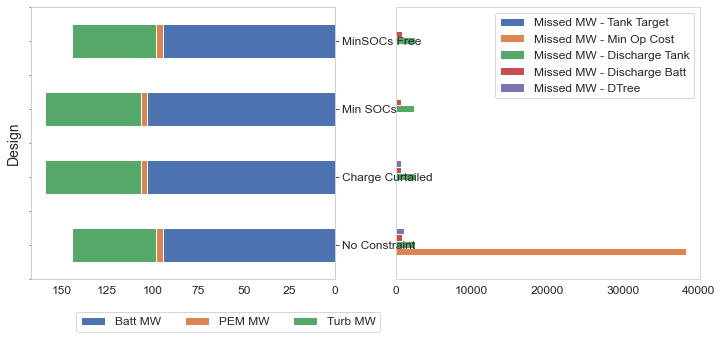

In [163]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
design_vs_op_df[["Batt MW", "PEM MW", "Turb MW"]].plot(kind='barh', stacked=True, ax=ax[0])
ax[0].invert_xaxis()
ax2 = ax[0].twinx()
ax2.set_ylim(ax[0].get_ylim())
ax2.set_yticks(ax[0].get_yticks())
ax2.set_yticklabels(ax[0].get_yticklabels())
ax[0].set_yticklabels([])
ax[0].set_yticks([])
ax[0].grid(False)
ax2.grid(False)
# plt.axis('off')
ax[0].legend(bbox_to_anchor=(.65,-0.1), loc="upper center", ncol=3)

design_vs_op_df[[ 'Missed MW - Tank Target',
       'Missed MW - Min Op Cost', 'Missed MW - Discharge Tank',
       'Missed MW - Discharge Batt', 'Missed MW - DTree']].plot(kind='barh', ax=ax[1])
ax[1].grid(False)

ax[1].set_yticklabels([])
ax[1].set_yticks([])


In [155]:
design_vs_op_df.columns

Index(['Wind MW', 'Batt MW', 'Batt MWh', 'PEM MW', 'Turb MW', 'Tank Ton',
       'Capital Cost', 'NPV', 'Missed MW - Tank Target',
       'Missed MW - Min Op Cost', 'Missed MW - Discharge Tank',
       'Missed MW - Discharge Batt', 'Missed MW - DTree'],
      dtype='object')

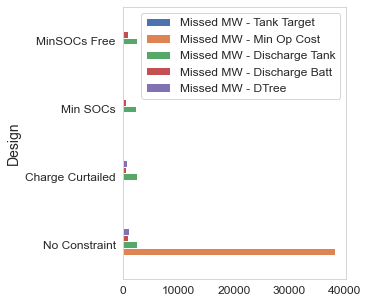

In [159]:
fig, ax = plt.subplots(figsize=(4, 5))
design_vs_op_df[[ 'Missed MW - Tank Target',
       'Missed MW - Min Op Cost', 'Missed MW - Discharge Tank',
       'Missed MW - Discharge Batt', 'Missed MW - DTree']].plot(kind='barh', ax=ax)
ax.grid(False)


tank target is ok
design opt is returning big batteries that aren't used in operation, which makes it easier for the operation models to succeed

In [375]:
print(pd.read_csv(results_dir / "dtree_1_minsocfree" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())


3294.9100000000003


In [376]:
print(pd.read_csv(results_dir / "tank_target_1_freeop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "discharge_tank_1_freeop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "discharge_batt_1_freeop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "dtree_12_1_freeop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "dtree_1_freeop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "min_op_cost_24_freeop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())

0.0
2572.54
851.9399999999999
1083.95
3487.06
38328.0


In [349]:
print(pd.read_csv(results_dir / "tank_target_1_modop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "discharge_tank_1_modop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "discharge_batt_1_modop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "dtree_12_1_modop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "dtree_1_modop_2" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "min_op_cost_24_modop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())

0.0
2496.7
635.6999999999999
14745.67
14745.67
0.0


In [325]:
print(pd.read_csv(results_dir / "tank_target_1_minsoc" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "discharge_tank_1_minsoc" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "discharge_batt_1_minsoc" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "dtree_6_1_minsoc" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "dtree_12_1_minsoc" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
# print(pd.read_csv(results_dir / "min_op_cost_24_minsoc" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())

2435.88
624.42
14745.42
0.0


In [359]:
year_results['Wind Excess [MW]'] = (year_results['Wind Max [MW]'] - year_results['Load [MW]']).clip(lower=0)
year_results['Wind Shortage [MW]'] = (year_results['Load [MW]'] - year_results['Wind Max [MW]']).clip(lower=0)
year_results['Previous State of Charge [MWh]'] = np.roll(year_results['State of Charge [MWh]'], 1)
year_results['Previous Tank Holdup [kg]'] = np.roll(year_results['Tank Holdup [kg]'], 1)
year_results['Ratio Battery Input to Nameplate [MW]'] = year_results['Wind Power to Battery [MW]'] / params['batt_mw']
year_results['Ratio PEM Input to Nameplate [MW]'] = year_results['Wind Power to PEM [MW]'] / params['pem_mw']
year_results['Ratio Battery Output to Nameplate [MW]'] = year_results['Battery Power Output [MW]'] / params['batt_mw']
year_results['Ratio Turbine Output to Nameplate [MW]'] = year_results['Turbine Power Output [MW]'] / params['turb_mw']

year_results['4-Hr Ahead Wind Excess [MW]'] = year_results['Wind Excess [MW]'][::-1].rolling(4, min_periods=0).sum()
year_results['16-Hr Ahead Wind Excess [MW]'] = year_results['Wind Excess [MW]'][::-1].rolling(16, min_periods=0).sum()
year_results['24-Hr Ahead Wind Excess [MW]'] = year_results['Wind Excess [MW]'][::-1].rolling(24, min_periods=0).sum()

year_results['4-Hr Ahead Wind Shortage [MW]'] = year_results['Wind Shortage [MW]'][::-1].rolling(4, min_periods=0).sum()
year_results['16-Hr Ahead Wind Shortage [MW]'] = year_results['Wind Shortage [MW]'][::-1].rolling(16, min_periods=0).sum()
year_results['24-Hr Ahead Wind Shortage [MW]'] = year_results['Wind Shortage [MW]'][::-1].rolling(24, min_periods=0).sum()

year_results.columns

input_cols = ['Previous State of Charge [MWh]', 'Previous Tank Holdup [kg]',
    'Wind Excess [MW]', 'Wind Shortage [MW]',  
    '4-Hr Ahead Wind Excess [MW]', 
    '16-Hr Ahead Wind Excess [MW]', '24-Hr Ahead Wind Excess [MW]',
    '4-Hr Ahead Wind Shortage [MW]', 
    '16-Hr Ahead Wind Shortage [MW]', '24-Hr Ahead Wind Shortage [MW]']
output_cols = ['Ratio Battery Input to Nameplate [MW]',
    'Ratio PEM Input to Nameplate [MW]',
    'Ratio Battery Output to Nameplate [MW]',
    'Ratio Turbine Output to Nameplate [MW]']

In [363]:
X = year_results[input_cols].to_numpy()
y = year_results[output_cols].to_numpy()

regtree = DecisionTreeRegressor(random_state=1, max_depth=12)
regfore = RandomForestRegressor(random_state=1, max_depth=10, n_estimators=2)
reglin = LinearRegression()

regtree.fit(X, y)
regfore.fit(X, y)
reglin.fit(X,y)

display(regtree.score(X, y), regfore.score(X, y), reglin.score(X, y))

graph = graphviz.Source(export_graphviz(regtree, filled=True), format='png')
graph.render("decision_tree_graphivz")

regtree.get_n_leaves()

0.9397588945510613

0.8430258190077531

0.28301362485831827

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.21883 to fit


1159

In [372]:
X[5081]

array([ 3.54829926e+02,  7.45543707e+03,  0.00000000e+00,  6.54965233e+01,
       -1.13686838e-13,  7.05467645e+02,  1.13814125e+03,  3.04843589e+02,
        3.04843589e+02,  3.04843589e+02])

In [371]:
regtree.predict([X[5081]])

array([[0.        , 0.01650806, 0.64025186, 0.00460534]])

In [364]:
y[5081]

array([ 0.        , -0.        ,  0.69433641,  0.        ])

In [361]:
year_results.iloc[5081]

Total Wind Generation [MW]                3.103477e+00
Total Power Output [MW]                   6.860000e+01
Wind Power Output [MW]                    3.103477e+00
Wind Power to Battery [MW]                0.000000e+00
State of Charge [MWh]                     2.858862e+02
Battery Power Output [MW]                 6.549652e+01
Wind Power to PEM [MW]                   -0.000000e+00
PEM H2 Output [kg]                        0.000000e+00
Tank H2 Input [kg]                       -0.000000e+00
H2 Sales [kg]                             0.000000e+00
Turbine H2 Input [kg]"                    0.000000e+00
Tank Holdup [kg]                          7.455437e+03
Turbine Power Output [MW]                 0.000000e+00
Load [MW]                                 6.860000e+01
Wind Max [MW]                             3.103477e+00
Wind Excess [MW]                          0.000000e+00
Wind Shortage [MW]                        6.549652e+01
Previous State of Charge [MWh]            3.548299e+02
Previous T

In [342]:
sorted(list(zip(input_cols, regtree.feature_importances_)), key=lambda row: -row[1])

[('Wind Excess [MW]', 0.8865079365507356),
 ('Previous Tank Holdup [kg]', 0.03807004894184608),
 ('24-Hr Ahead Wind Shortage [MW]', 0.03703175652639796),
 ('Previous State of Charge [MWh]', 0.013153683286479156),
 ('16-Hr Ahead Wind Shortage [MW]', 0.006147667447481937),
 ('16-Hr Ahead Wind Excess [MW]', 0.005483917935614294),
 ('24-Hr Ahead Wind Excess [MW]', 0.005121149627659633),
 ('4-Hr Ahead Wind Excess [MW]', 0.0037377236011329313),
 ('Wind Shortage [MW]', 0.003560407700305197),
 ('4-Hr Ahead Wind Shortage [MW]', 0.0011857083823471135)]

In [230]:
graph = graphviz.Source(export_graphviz(regfore.estimators_[0], filled=True), format='png')
graph.render("random_forest_graphivz")

'random_forest_graphivz.png'

In [116]:
# is battery or PEM receiving energy whenever there is less than enough wind?

display(year_results.columns)
not_enough_wind_mask = year_results['Wind Power Output [MW]'] < loads_mw
df_not_enough_wind = year_results[not_enough_wind_mask]
df_not_enough_wind['Wind Power to Battery [MW]'].max(), df_not_enough_wind['Wind Power to PEM [MW]'].max()

Index(['Total Wind Generation [MW]', 'Total Power Output [MW]',
       'Wind Power Output [MW]', 'Wind Power to Battery [MW]',
       'State of Charge [MWh]', 'Battery Power Output [MW]',
       'Wind Power to PEM [MW]', 'PEM H2 Output [kg]', 'Tank H2 Input [kg]',
       'H2 Sales [kg]', 'Turbine H2 Input [kg]"', 'Tank Holdup [kg]',
       'Turbine Power Output [MW]', 'Load [MW]'],
      dtype='object')

(63.9552885746464, 3.773)

In [117]:
print("Time the PEM and Batt are both receiving energy when wind is not enough", 
    df_not_enough_wind[df_not_enough_wind['Wind Power to PEM [MW]'] > 0]['Wind Power to Battery [MW]'].max())
print("Time the PEM and Batt are both receiving energy when wind is not enough", 
    df_not_enough_wind[df_not_enough_wind['Wind Power to Battery [MW]'] > 0]['Wind Power to PEM [MW]'].max())

print("Wind is going to PEM while Battery is discharging", 
    df_not_enough_wind[df_not_enough_wind['Wind Power to PEM [MW]'] > 0]['Battery Power Output [MW]'].max())

print("Wind is going to Battery while Turbine is firing", 
    df_not_enough_wind[df_not_enough_wind['Turbine Power Output [MW]'] > 0]['Wind Power to Battery [MW]'].max())

Time the PEM and Batt are both receiving energy when wind is not enough 0.0
Time the PEM and Batt are both receiving energy when wind is not enough 0.0
Wind is going to PEM while Battery is discharging 94.33
Wind is going to Battery while Turbine is firing 63.9552885746464


In [113]:
# turbine is discharging while wind is charging battery
df_not_enough_wind[df_not_enough_wind['Wind Power to Battery [MW]'] > 0]

,Total Wind Generation [MW],Total Power Output [MW],Wind Power Output [MW],Wind Power to Battery [MW],State of Charge [MWh],Battery Power Output [MW],Wind Power to PEM [MW],PEM H2 Output [kg],Tank H2 Input [kg],H2 Sales [kg],"Turbine H2 Input [kg]""",Tank Holdup [kg],Turbine Power Output [MW],Load [MW]


In [47]:
# battery is dicharging while wind is making H2
df_not_enough_wind[df_not_enough_wind['Wind Power to PEM [MW]'] > 0]

,Total Wind Generation [MW],Total Power Output [MW],Wind Power Output [MW],Wind Power to Battery [MW],State of Charge [MWh],Battery Power Output [MW],Wind Power to PEM [MW],PEM H2 Output [kg],Tank H2 Input [kg],H2 Sales [kg],"Turbine H2 Input [kg]""",Tank Holdup [kg],Turbine Power Output [MW],Load [MW]
15,4.143000,94.7,0.370000,0.0,502.757895,94.330000,3.773,68.6585,68.6585,0.0,0.0,92139.707582,0.0,94.7
16,59.943000,150.5,56.170000,0.0,403.463158,94.330000,3.773,68.6585,68.6585,0.0,0.0,92208.366082,0.0,150.5
17,24.643000,115.2,20.870000,0.0,304.168421,94.330000,3.773,68.6585,68.6585,0.0,0.0,92277.024583,0.0,115.2
18,19.043000,109.6,15.270000,0.0,204.873684,94.330000,3.773,68.6585,68.6585,0.0,0.0,92345.683083,0.0,109.6
27,85.643000,176.2,81.870000,0.0,105.578947,94.330000,3.773,68.6585,68.6585,0.0,0.0,92963.609587,0.0,176.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8735,13.243000,103.8,9.470000,0.0,82.868870,94.330000,3.773,68.6585,68.6585,0.0,0.0,89050.075062,0.0,103.8
8737,107.572038,128.9,103.799038,0.0,99.294737,25.100962,3.773,68.6585,68.6585,0.0,0.0,89187.392063,0.0,128.9
8743,32.143000,122.7,28.370000,0.0,0.000000,94.330000,3.773,68.6585,68.6585,0.0,0.0,89599.343066,0.0,122.7
8763,99.643000,190.2,95.870000,0.0,617.613263,94.330000,3.773,68.6585,68.6585,0.0,0.0,90972.513075,0.0,190.2


In [72]:
# is battery or turbine making power whenever there is enough wind?

enough_wind_mask = year_results['Wind Power Output [MW]'] >= loads_mw
df_enough_wind = year_results[enough_wind_mask]
df_enough_wind['Battery Power Output [MW]'].max(), df_enough_wind['Turbine Power Output [MW]'].max()

# That's good! Then we need to know where the excess is going... 
# Charging simultaneously? Yes

df_enough_wind[(df_enough_wind['Wind Power to Battery [MW]'] > 0) & (df_enough_wind['Wind Power to PEM [MW]'] > 0)][["Wind Power to PEM [MW]", "Wind Power to Battery [MW]"]].describe()



,Wind Power to PEM [MW],Wind Power to Battery [MW]
count,1269.000000,1.269000e+03
mean,3.770033,7.377137e+01
std,0.105698,2.988384e+01
min,0.007721,1.364242e-15
25%,3.773000,5.279081e+01
50%,3.773000,9.433000e+01
75%,3.773000,9.433000e+01
max,3.773000,9.433000e+01


In [74]:
df_enough_wind[(df_enough_wind['Wind Power to Battery [MW]'] > 0)][["Wind Power to PEM [MW]", "Wind Power to Battery [MW]"]].describe()


,Wind Power to PEM [MW],Wind Power to Battery [MW]
count,1785.000000,1.785000e+03
mean,2.680208,5.558375e+01
std,1.711881,3.884620e+01
min,0.000000,1.364242e-15
25%,0.000000,1.371009e+01
50%,3.773000,6.521341e+01
75%,3.773000,9.433000e+01
max,3.773000,9.433000e+01


In [75]:
df_enough_wind[(df_enough_wind['Wind Power to PEM [MW]'] > 0)][["Wind Power to PEM [MW]", "Wind Power to Battery [MW]"]].describe()


,Wind Power to PEM [MW],Wind Power to Battery [MW]
count,4246.000000,4.246000e+03
mean,3.771954,2.204801e+01
std,0.058707,3.751562e+01
min,0.007721,-5.657057e-13
25%,3.773000,0.000000e+00
50%,3.773000,0.000000e+00
75%,3.773000,3.279208e+01
max,3.773000,9.433000e+01


In [200]:
df_not_enough_wind[(df_not_enough_wind['Battery Power Output [MW]'] > 0)]

,Total Wind Generation [MW],Total Power Output [MW],Wind Power Output [MW],Wind Power to Battery [MW],State of Charge [MWh],Battery Power Output [MW],Wind Power to PEM [MW],PEM H2 Output [kg],Tank H2 Input [kg],H2 Sales [kg],"Turbine H2 Input [kg]""",Tank Holdup [kg],Turbine Power Output [MW],Load [MW]
13,0.000,53.2,0.00,0.0,651.631579,53.20,0.000,0.0000,0.0000,0.0,0.0,92071.049081,0.0,53.2
14,0.000,47.1,0.00,0.0,602.052632,47.10,0.000,0.0000,0.0000,0.0,0.0,92071.049081,0.0,47.1
15,4.143,94.7,0.37,0.0,502.757895,94.33,3.773,68.6585,68.6585,0.0,0.0,92139.707582,0.0,94.7
16,59.943,150.5,56.17,0.0,403.463158,94.33,3.773,68.6585,68.6585,0.0,0.0,92208.366082,0.0,150.5
17,24.643,115.2,20.87,0.0,304.168421,94.33,3.773,68.6585,68.6585,0.0,0.0,92277.024583,0.0,115.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,0.000,8.2,0.00,0.0,202.318526,8.20,0.000,0.0000,0.0000,0.0,0.0,91178.488576,0.0,8.2
8780,0.000,6.8,0.00,0.0,195.160632,6.80,0.000,0.0000,0.0000,0.0,0.0,91178.488576,0.0,6.8
8781,0.000,4.8,0.00,0.0,190.108000,4.80,0.000,0.0000,0.0000,0.0,0.0,91178.488576,0.0,4.8
8782,0.000,7.9,0.00,0.0,181.792211,7.90,0.000,0.0000,0.0000,0.0,0.0,91178.488576,0.0,7.9


## Surrogate Model

In [2]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from pyvis.network import Network
from functools import reduce

from dispatches_sample_data import rts_gmlc
from dispatches.case_studies.renewables_case.double_loop_utils import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("deep")

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

pd.set_option('display.max_columns', None)

if os.environ.get("NREL_CLUSTER"):
    workspace_dir = Path("/projects/gmihybridsys/dguittet/workspace")
    dispatches_dir = Path("/projects/gmihybridsys/dguittet/dispatches/dispatches/case_studies/renewables_h2_case")
else:
    workspace_dir = Path("/Users/dguittet/Projects/Dispatches/workspace")
    dispatches_dir = Path("/Users/dguittet/Projects/Dispatches/dispatches/dispatches/case_studies/renewables_h2_case")

rts_gmlc_dir = workspace_dir / "prescient_runs/simulate_with_network_with_uncertainty_w_15_reserves_500_shortfall_eagle"

In [3]:
rts_gmlc_graph, line_df, branch_df, gen_df, summary = get_rtsgmlc_network(rts_gmlc_dir, rts_gmlc.source_data_path)
bus_dict = get_rtsgmlc_bus_dict(rts_gmlc.source_data_path)
bid_df = pd.read_csv(rts_gmlc.source_data_path / "gen.csv")
bid_df = bid_df[bid_df['Fuel'] == "NG"]
ng_gens = bid_df['GEN UID'].unique()
bid_df = bid_df.rename(columns={"GEN UID": "Generator"})


In [4]:
gen_df["Type"] = "NA"
gen_df.loc[gen_df['Generator'].str.contains("CC"), "Type"] = "CC"
gen_df.loc[gen_df['Generator'].str.contains("CT"), "Type"] = "CT"
gen_df[(gen_df["Type"] == "CT") | (gen_df["Type"] == "CC")].describe()

,Output,Output DA,Curtailment,Unit Market Revenue,Unit Uplift Payment,Dispatch,Dispatch DA,Headroom,Unit Cost
count,0.0,0.0,0.0,430416.000000,430416.0,430416.000000,430416.000000,430416.000000,430416.000000
mean,NaN,NaN,NaN,610.807387,0.0,15.804734,16.269232,12.121299,555.011400
std,NaN,NaN,NaN,2936.440500,0.0,53.792470,55.447145,42.560721,2369.660877
min,NaN,NaN,NaN,-9250.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,NaN,NaN,NaN,127406.477902,0.0,355.000000,355.000000,185.000000,35570.200971


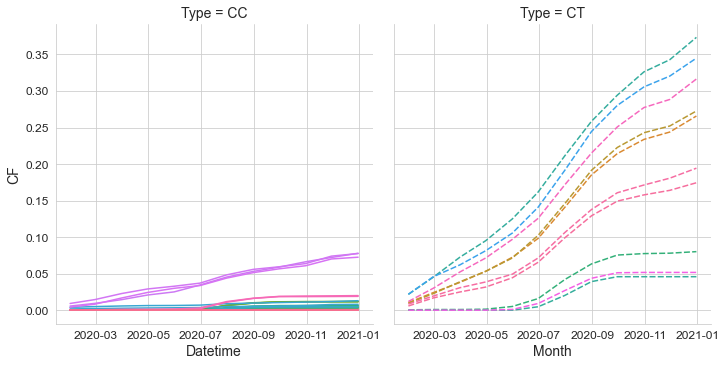

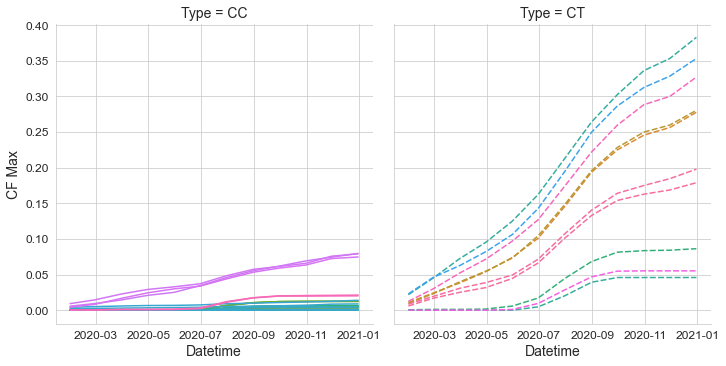

In [110]:
ng_df = gen_df.groupby("Generator").resample("1M").sum().reset_index()
ng_df["Dispatch Cml"] = ng_df.groupby('Generator').cumsum().reset_index()['Dispatch']
ng_df["Dispatch DA Cml"] = ng_df.groupby('Generator').cumsum().reset_index()['Dispatch DA']
ng_df["Type"] = "CC"
ng_df.loc[ng_df['Generator'].str.contains("CC"), "Type"] = "CT"

ng_df['CF'] = 0
for gen in ng_gens:
    ng_df.loc[ng_df['Generator'] == gen, "CF"] = ng_df.loc[ng_df['Generator'] == gen, "Dispatch Cml"] / bid_df[bid_df['Generator'] ==  gen]["PMax MW"].unique()[0] / 8760
    ng_df.loc[ng_df['Generator'] == gen, "CF Max"] = ng_df.loc[ng_df['Generator'] == gen][["Dispatch Cml", "Dispatch DA Cml"]].max(axis=1) / bid_df[bid_df['Generator'] ==  gen]["PMax MW"].unique()[0] / 8760


sns.relplot(
    data=ng_df, y="CF", x="Datetime", hue="Generator", style='Type',
    col="Type", kind="line", legend=False
)
plt.xlabel("Month")

sns.relplot(
    data=ng_df, y="CF Max", x="Datetime", hue="Generator", style='Type',
    col="Type", kind="line", legend=False
)

In [6]:
from scipy.optimize import curve_fit, least_squares

def func(month, L, k, x_0, a, b):
    return L / (1 + np.exp(-k * (month - x_0))) + (a * month + b) * 0

X = []
y = []
bid_df["L"] = np.nan
bid_df["L_abs"] = np.nan
bid_df["k"] = np.nan
bid_df['x_0'] = np.nan

xdata = np.array(range(0, 12)) / 12
for gen in ng_gens:
    # fig = plt.figure()
    ydata = ng_df[ng_df['Generator'] == gen]['CF'].values
    pmax = bid_df[bid_df['Generator'] == gen]['PMax MW'].values[0]
    try:
        popt, pcov = curve_fit(func, xdata, ydata)
    except:
        # plt.plot(xdata, ydata, 'b-', label='data, no fit')
        continue
    display(popt)
    # plt.plot(xdata, ydata * 8760 * pmax, 'b-', label='data')
    # plt.plot(xdata, func(xdata, *popt)* 8760 * pmax, 'r-', label='fit: L=%5.3f, k=%5.3f, x_0=%5.3f, a=%5.3f, b=%5.3f' % tuple(popt))
    # plt.legend()
    # X.append()
    bid_df.loc[bid_df['Generator'] == gen, "L"] = popt[0]
    bid_df.loc[bid_df['Generator'] == gen, "L_abs"] = popt[0] * pmax * 8760
    bid_df.loc[bid_df['Generator'] == gen, "k"] = popt[1]
    bid_df.loc[bid_df['Generator'] == gen, "x_0"] = popt[2]
    # break

/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


array([0.28211562, 6.21738534, 0.49592998, 1.        , 1.        ])

array([2.52798232e-03, 3.74844635e+01, 4.93909544e-01, 1.00000000e+00,
       1.00000000e+00])

array([3.54594927e-03, 4.91317104e+01, 4.90664754e-01, 1.00000000e+00,
       1.00000000e+00])

array([3.49343681e-03, 3.31632248e+01, 4.96953586e-01, 1.00000000e+00,
       1.00000000e+00])

array([3.14072318e-03, 5.22054329e+01, 4.91635227e-01, 1.00000000e+00,
       1.00000000e+00])

array([0.28755581, 6.481355  , 0.49092726, 1.        , 1.        ])

array([1.13826109e-02, 2.69892677e+01, 4.94567113e-01, 1.00000000e+00,
       1.00000000e+00])

array([1.16347692e-02, 2.86542500e+01, 4.93535113e-01, 1.00000000e+00,
       1.00000000e+00])

array([1.14261489e-02, 2.72371616e+01, 4.97451533e-01, 1.00000000e+00,
       1.00000000e+00])

array([6.31906111e-03, 2.87751385e+01, 5.02736886e-01, 1.00000000e+00,
       1.00000000e+00])

array([5.8026517e-03, 3.1011934e+01, 5.0059697e-01, 1.0000000e+00,
       1.0000000e+00])

array([ 0.07907562, 16.71253443,  0.49558116,  1.        ,  1.        ])

array([3.85080449e-03, 3.05018278e+01, 4.99275485e-01, 1.00000000e+00,
       1.00000000e+00])

array([4.06852577e-03, 2.36501444e+01, 4.96438562e-01, 1.00000000e+00,
       1.00000000e+00])

array([ 4.90867580e-04, -1.30123418e+01,  7.06173375e+00,  1.00000000e+00,
        1.00000000e+00])

array([ 0.04604723, 24.10619847,  0.51016609,  1.        ,  1.        ])

array([0.40809107, 5.20136232, 0.48634544, 1.        , 1.        ])

array([1.82648402e-04, 5.96819861e+02, 4.58420741e-01, 1.00000000e+00,
       1.00000000e+00])

array([1.36986301e-04, 5.94233921e+02, 4.58762418e-01, 1.00000000e+00,
       1.00000000e+00])

array([9.26885331e-39, 9.99999955e-01, 1.00000015e+00, 1.00000000e+00,
       1.00000000e+00])

array([4.81769916e-03, 2.43275451e+01, 5.15197896e-01, 1.00000000e+00,
       1.00000000e+00])

array([4.13748324e-03, 4.09020326e+01, 4.94997479e-01, 1.00000000e+00,
       1.00000000e+00])

array([0.01704214, 2.23104257, 0.95799853, 1.        , 1.        ])

array([0.02078377, 2.0548616 , 0.6812864 , 1.        , 1.        ])

array([0.37764093, 5.47974751, 0.49001569, 1.        , 1.        ])

array([0.08611018, 4.98532299, 0.49606261, 1.        , 1.        ])

array([0.09124916, 3.85247073, 0.48599313, 1.        , 1.        ])

array([0.07962316, 4.81586362, 0.46281345, 1.        , 1.        ])

array([ 0.05196016, 20.03200941,  0.49675006,  1.        ,  1.        ])

array([0.34069221, 5.67723996, 0.49523557, 1.        , 1.        ])

array([1.86502993e-02, 2.34280429e+01, 4.90887464e-01, 1.00000000e+00,
       1.00000000e+00])

array([ 0.019571  , 19.19363819,  0.48741692,  1.        ,  1.        ])

array([0.2061793 , 6.36040577, 0.49085956, 1.        , 1.        ])

array([0.18113286, 7.13283376, 0.47357335, 1.        , 1.        ])

In [7]:
fit_df = bid_df.drop(columns=bid_df.columns[bid_df.isna().any()].tolist()[:-4])
fit_df = fit_df.dropna(axis=0)

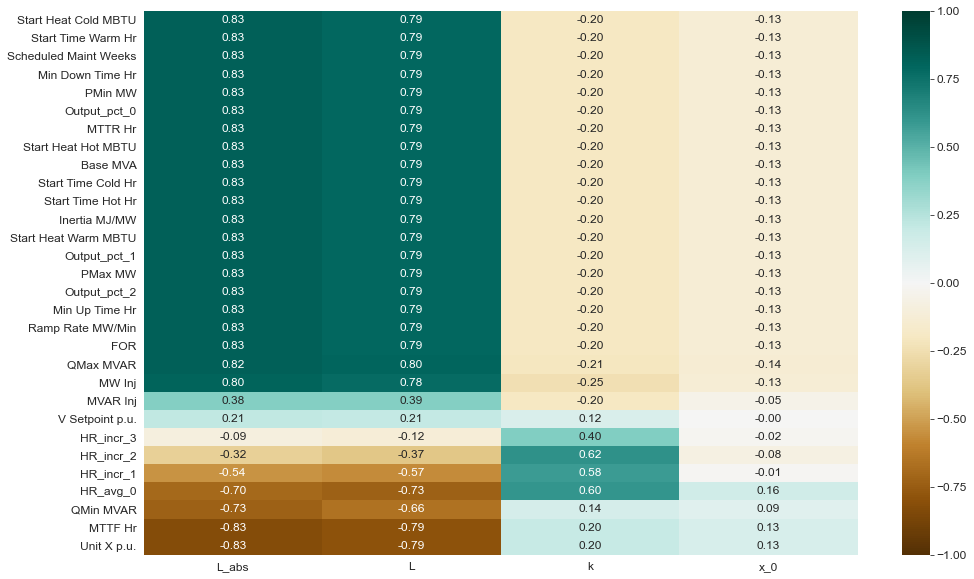

In [8]:
output_cols = ["L_abs", "L", 'k', 'x_0']
input_cols = set(fit_df.columns).difference(set(output_cols))
corr_df = fit_df.dropna(axis=1).drop(columns=["Bus ID", "Gen ID"])
corr_df = corr_df.corr().loc[corr_df.corr().index.isin(input_cols)][output_cols].dropna(axis=0)
input_cols = corr_df.index
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(corr_df.sort_values(by=output_cols, ascending=False), vmin=-1, vmax=1, cmap='BrBG', annot=True, fmt=".2f")


In [97]:
fit_df[output_cols].describe()

,L_abs,L,k,x_0
count,3.200000e+01,32.000000,32.000000,32.000000
mean,2.258428e+05,0.083437,55.907820,0.511656
std,3.971897e+05,0.123815,142.249007,0.088977
min,6.600000e+01,0.000137,2.054862,0.458421
25%,1.985133e+03,0.004120,6.082349,0.490502
50%,8.598309e+03,0.017846,23.539094,0.494782
75%,1.826666e+05,0.087395,30.629354,0.497078
max,1.269082e+06,0.408091,596.819861,0.957999


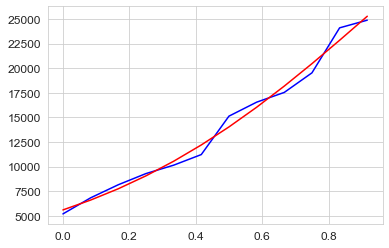

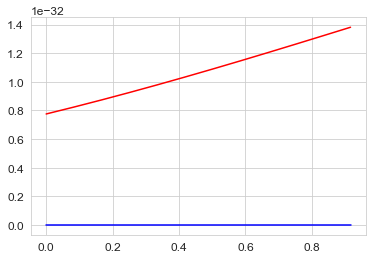

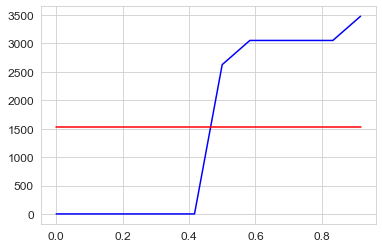

In [11]:
for i, tmp in fit_df.sort_values("x_0").tail(3).iterrows():
    gen = tmp['Generator']
    ydata = ng_df[ng_df['Generator'] == gen]['CF'].values
    plt.figure()
    plt.plot(xdata, ydata * 8760 * pmax, 'b-', label='data')
    popt = tmp["L"], tmp['k'], tmp['x_0'], 0, 0
    plt.plot(xdata, func(xdata, *popt)* 8760 * pmax, 'r-', label='fit: L=%5.3f, k=%5.3f, x_0=%5.3f, a=%5.3f, b=%5.3f' % tuple(popt))

In [12]:
fit_df = fit_df[fit_df['x_0'] <= 1]

<AxesSubplot:xlabel='HR_avg_0', ylabel='x_0'>

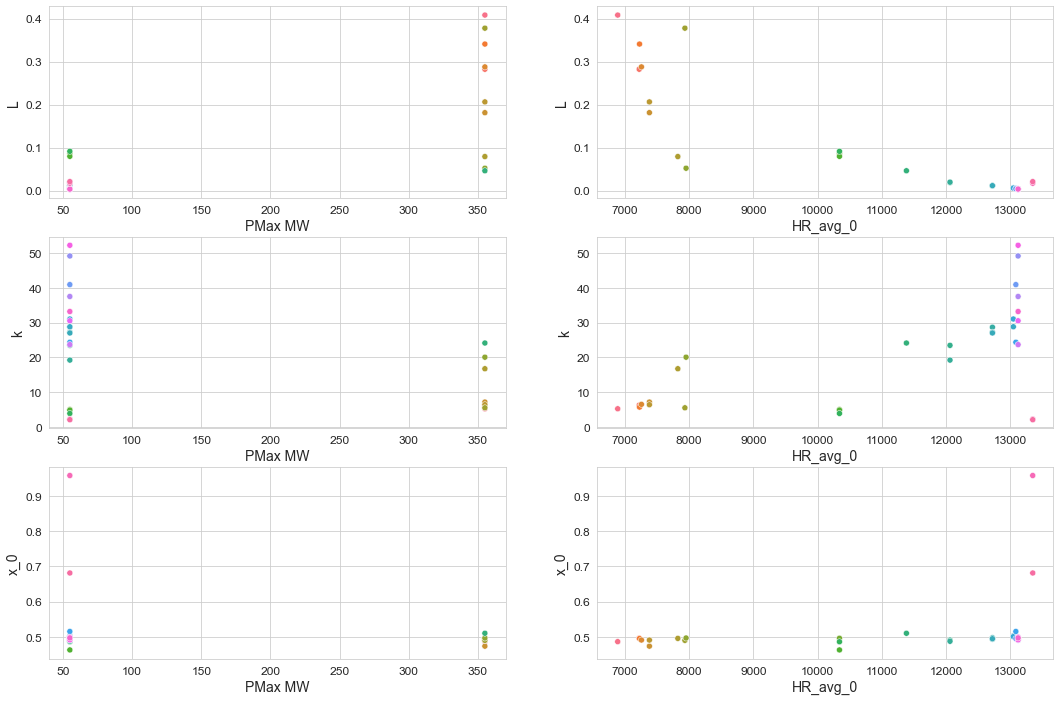

In [105]:
fig, ax = plt.subplots(3, 2, figsize=(18, 12))
sns.scatterplot(ax=ax[0, 0],
    data=fit_df.sort_values("HR_avg_0").head(-2), y="L", x="PMax MW", hue="Generator", legend=False
)
sns.scatterplot(ax=ax[0, 1],
    data=fit_df.sort_values("HR_avg_0").head(-2), y="L", x="HR_avg_0", hue="Generator", legend=False
)
sns.scatterplot(ax=ax[1, 0],
    data=fit_df.sort_values("HR_avg_0").head(-2), y="k", x="PMax MW", hue="Generator", legend=False
)
sns.scatterplot(ax=ax[1, 1],
    data=fit_df.sort_values("HR_avg_0").head(-2), y="k", x="HR_avg_0", hue="Generator", legend=False
)
sns.scatterplot(ax=ax[2, 0],
    data=fit_df.sort_values("HR_avg_0").head(-2), y="x_0", x="PMax MW", hue="Generator", legend=False
)
sns.scatterplot(ax=ax[2, 1],
    data=fit_df.sort_values("HR_avg_0").head(-2), y="x_0", x="HR_avg_0", hue="Generator", legend=False
)

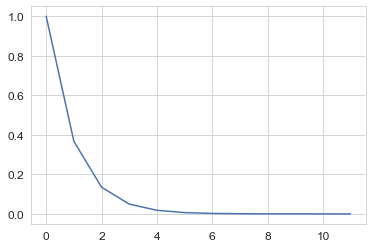

In [100]:
x = np.array(range(0, 12))
plt.plot(x, np.exp(-x))

In [15]:
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer

input_cols = corr_df.index

X = fit_df[input_cols].to_numpy()
for i in range(1, 4):
    y = fit_df[output_cols[i]].to_numpy()

    regtree = DecisionTreeRegressor(random_state=1)
    regtree.fit(X, y)

    reglin = LinearRegression()
    reglin.fit(X, y)

    display(regtree.score(X, y), reglin.score(X,y))
    display(sorted(list(zip(input_cols, regtree.feature_importances_)), key=lambda row: -row[1])[0:10])

0.9992942923930724

0.9055890645042558

[('HR_avg_0', 0.8178045029248157),
 ('HR_incr_1', 0.13334879964555782),
 ('HR_incr_3', 0.04258505742308029),
 ('HR_incr_2', 0.005165140819807301),
 ('MW Inj', 0.00097678873646267),
 ('QMin MVAR', 0.00011514128244302105),
 ('V Setpoint p.u.', 4.5691678332025145e-06),
 ('MVAR Inj', 0.0),
 ('PMax MW', 0.0),
 ('PMin MW', 0.0)]

0.9993181168847594

0.9192432453625335

[('MW Inj', 0.9909999698496379),
 ('HR_avg_0', 0.007149723396743596),
 ('V Setpoint p.u.', 0.0008231883629169072),
 ('HR_incr_1', 0.00077611065411895),
 ('MVAR Inj', 0.00024189085230022094),
 ('Min Up Time Hr', 8.31035645737603e-06),
 ('QMax MVAR', 5.547815921488507e-07),
 ('HR_incr_2', 2.5174623292418664e-07),
 ('PMax MW', 0.0),
 ('PMin MW', 0.0)]

0.842180944833936

0.6262351447925677

[('V Setpoint p.u.', 0.9792579062421706),
 ('HR_incr_2', 0.013533935713163971),
 ('QMin MVAR', 0.004708296046353609),
 ('HR_incr_3', 0.0017595416486908216),
 ('MVAR Inj', 0.00043958722934811186),
 ('HR_incr_1', 0.000158985929356504),
 ('HR_avg_0', 0.00011302418640005324),
 ('Output_pct_2', 2.5409137192294014e-05),
 ('Start Time Cold Hr', 3.3044355645841104e-06),
 ('MTTF Hr', 9.431759446824364e-09)]

In [348]:
input_cols = ['HR_avg_0', 'HR_incr_1', 'HR_incr_2', 'MVAR Inj', 'Start Heat Warm MBTU',
 'HR_incr_3', 'MW Inj', 'QMax MVAR']

X = fit_df[input_cols].to_numpy()
y = fit_df[output_cols[1:]].to_numpy()

regtree = DecisionTreeRegressor(random_state=1)
poly = PolynomialFeatures(len(input_cols))
X_poly = poly.fit_transform(X)
reglin = LinearRegression()

regtree.fit(X, y)
reglin.fit(X_poly, y)

display(regtree.score(X, y), reglin.score(X_poly,y))
sorted(list(zip(input_cols, regtree.feature_importances_)), key=lambda row: -row[1])[0:10]

0.8739091099367372

0.6813114257358892

[('MW Inj', 0.9831867108842558),
 ('HR_incr_2', 0.008790981157429297),
 ('QMax MVAR', 0.003086957164732076),
 ('HR_incr_3', 0.0018300300749395976),
 ('HR_avg_0', 0.0014188559205610106),
 ('MVAR Inj', 0.0009474269785176178),
 ('HR_incr_1', 0.0007390378195645957),
 ('Start Heat Warm MBTU', 0.0)]

In [25]:
fit_df[input_cols + output_cols].corr()

,HR_avg_0,HR_incr_1,HR_incr_2,PMax MW,L_abs,L,k,x_0
HR_avg_0,1.000000,0.732221,0.683014,-0.777092,-0.720870,-0.750976,0.710228,0.093361
HR_incr_1,0.732221,1.000000,0.895072,-0.539210,-0.559324,-0.579859,0.664153,0.017887
HR_incr_2,0.683014,0.895072,1.000000,-0.418869,-0.327837,-0.374985,0.718115,-0.068818
PMax MW,-0.777092,-0.539210,-0.418869,1.000000,0.822842,0.788981,-0.219427,-0.147174
L_abs,-0.720870,-0.559324,-0.327837,0.822842,1.000000,0.986734,-0.201329,-0.134958
L,-0.750976,-0.579859,-0.374985,0.788981,0.986734,1.000000,-0.235981,-0.135265
k,0.710228,0.664153,0.718115,-0.219427,-0.201329,-0.235981,1.000000,-0.181804
x_0,0.093361,0.017887,-0.068818,-0.147174,-0.134958,-0.135265,-0.181804,1.000000


In [24]:
fit_df.sort_values("HR_avg_0")[input_cols + output_cols].tail()

,HR_avg_0,HR_incr_1,HR_incr_2,PMax MW,L_abs,L,k,x_0
11,13125.0,6899.0,7602.0,55.0,1683.137855,0.003493,33.163225,0.496954
54,13353.0,7176.0,7517.0,55.0,8210.903792,0.017042,2.231043,0.957999
55,13353.0,7176.0,7517.0,55.0,10013.622433,0.020784,2.054862,0.681286
44,19794.0,9595.0,10225.0,55.0,66.000000,0.000137,594.233921,0.458762
43,19794.0,9595.0,10225.0,55.0,88.000000,0.000183,596.819861,0.458421


In [77]:
fit_df[output_cols].describe()

,L_abs,L,k,x_0
count,3.200000e+01,32.000000,32.000000,32.000000
mean,2.258428e+05,0.083437,55.907820,0.511656
std,3.971897e+05,0.123815,142.249007,0.088977
min,6.600000e+01,0.000137,2.054862,0.458421
25%,1.985133e+03,0.004120,6.082349,0.490502
50%,8.598309e+03,0.017846,23.539094,0.494782
75%,1.826666e+05,0.087395,30.629354,0.497078
max,1.269082e+06,0.408091,596.819861,0.957999


In [87]:
input_cols = ['HR_avg_0', 
# 'HR_incr_1', 'HR_incr_2', 
'PMax MW']
 
for i in range(1, 3):
    X = fit_df[input_cols].to_numpy()
    y = fit_df[output_cols[i]].to_numpy()

    poly = PolynomialFeatures(1)
    X_poly = poly.fit_transform(X)
    # X_poly[:, 4] = 0
    regpoly = LinearRegression()
    regpoly.fit(X_poly, y)

    print("score", regpoly.score(X_poly,y))
    print("predicted", regpoly.predict(poly.fit_transform([[11616, 200]])))
    print("coefs", sorted(list(zip(regpoly.coef_, poly.get_feature_names_out(input_cols))), key=lambda r: -abs(r[0])))
    print("intercept", regpoly.intercept_)

score 0.6704730306219532
predicted [0.10564726]
coefs [(0.0004544309073947671, 'PMax MW'), (-1.3249808016773351e-05, 'HR_avg_0'), (0.0, '1')]
intercept 0.16867085170938118
score 0.7834887743498
predicted [104.07407694]
coefs [(0.8450987336011131, 'PMax MW'), (0.05959275349966654, 'HR_avg_0'), (0.0, '1')]
intercept -757.1750944368994


In [88]:
regpoly.predict(poly.fit_transform(X))

array([-26.78617823,  71.46022559,  71.46022559,  71.46022559,
        71.46022559, -24.70043186,  47.62312419,  47.62312419,
        47.62312419,  67.05036184,  67.05036184,   9.08865937,
        71.46022559,  71.46022559, 221.29845459, -46.74975066,
       468.88429868, 468.88429868,  69.37447922,  69.37447922,
        85.04737339,  85.04737339,  15.64386226, -94.3864074 ,
       -94.3864074 , -94.3864074 ,  16.71653182, -26.48821447,
         8.23231413,   8.23231413, -17.31093043, -17.31093043])

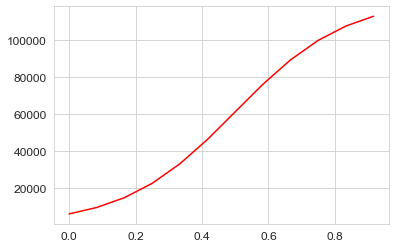

In [79]:
plt.figure()
popt = 0.03932, 5.9747, 0.5, 0, 0
plt.plot(xdata, func(xdata, *popt)* 8760 * pmax, 'r-', label='fit: L=%5.3f, k=%5.3f, x_0=%5.3f, a=%5.3f, b=%5.3f' % tuple(popt))

In [64]:
input_cols = [['HR_avg_0', 'HR_incr_1', 'HR_incr_2'],
            ['HR_incr_2', 'HR_incr_3', 'HR_avg_0'],
            ['HR_avg_0', 'HR_incr_1', 'HR_incr_2']]
 
for i in range(1, 4):
    X = fit_df[input_cols[i-1]].to_numpy()
    y = fit_df[output_cols[i]].to_numpy()

    regtree = DecisionTreeRegressor(random_state=1)
    regtree.fit(X, y)

    poly = PolynomialFeatures(2)
    X_poly = poly.fit_transform(X)
    regpoly = LinearRegression()
    regpoly.fit(X_poly, y)

    display(regtree.score(X, y), regpoly.score(X_poly,y))
    display(sorted(list(zip(input_cols[i-1], regtree.feature_importances_)), key=lambda row: -row[1])[0:10])
    display(sorted(list(zip(regpoly.coef_, poly.get_feature_names_out(input_cols[i-1]))), key=lambda r: -abs(r[0]))[0:10])
    display(regpoly.intercept_)    

0.9991775138273445

0.9235538152034884

[('HR_avg_0', 0.8379379553608413),
 ('HR_incr_1', 0.13518354426538326),
 ('HR_incr_2', 0.02687850037377545)]

[(-0.0005530116501883573, 'HR_incr_1'),
 (0.00039970639741161316, 'HR_incr_2'),
 (-0.00013340776436386218, 'HR_avg_0'),
 (1.0130520755894108e-07, 'HR_incr_1 HR_incr_2'),
 (-6.652531617594743e-08, 'HR_incr_1^2'),
 (5.9059127521706714e-08, 'HR_avg_0 HR_incr_1'),
 (-5.241336074724642e-08, 'HR_incr_2^2'),
 (-2.594728769271217e-08, 'HR_avg_0 HR_incr_2'),
 (-4.944897262723646e-09, 'HR_avg_0^2'),
 (0.0, '1')]

1.501384996648301

0.9987792124279308

0.9946452749231666

[('HR_avg_0', 0.9996117581519194),
 ('HR_incr_2', 0.0003605927942086363),
 ('HR_incr_3', 2.7649053871950638e-05)]

[(-0.21272584613156223, 'HR_incr_2'),
 (-0.1719720469460552, 'HR_avg_0'),
 (-0.01147721160802191, 'HR_incr_3'),
 (-3.597628113240561e-05, 'HR_incr_2 HR_incr_3'),
 (2.661748164822439e-05, 'HR_incr_2^2'),
 (1.2262740669455319e-05, 'HR_incr_2 HR_avg_0'),
 (1.0591135229304216e-05, 'HR_incr_3^2'),
 (6.115038514123428e-06, 'HR_incr_3 HR_avg_0'),
 (1.6113006688633913e-06, 'HR_avg_0^2'),
 (0.0, '1')]

1826.6370773294511

0.8399053029337732

0.2943520290699585

[('HR_incr_2', 0.6336291839296514),
 ('HR_avg_0', 0.3634252447122969),
 ('HR_incr_1', 0.0029455713580516826)]

[(0.0016238840317316949, 'HR_incr_2'),
 (-0.0014843534679819723, 'HR_incr_1'),
 (0.00011661019024086907, 'HR_avg_0'),
 (2.0492615450633612e-07, 'HR_incr_1 HR_incr_2'),
 (-1.732808702447747e-07, 'HR_incr_2^2'),
 (-5.286175825139973e-08, 'HR_avg_0 HR_incr_2'),
 (3.04491412675989e-08, 'HR_avg_0 HR_incr_1'),
 (-1.70508665969114e-08, 'HR_incr_1^2'),
 (3.6878851264438668e-09, 'HR_avg_0^2'),
 (0.0, '1')]

-1.1520517250751554

In [85]:
fit_df['HR_avg_to_incr_1'] = fit_df['HR_incr_1'] / fit_df['HR_avg_0']
fit_df['HR_avg_to_incr_2'] = fit_df['HR_incr_2'] / fit_df['HR_avg_0']
fit_df[set(np.array(input_cols + ["HR_avg_to_incr_1", "HR_avg_to_incr_2"]).flatten())].describe()

,PMax MW,HR_avg_to_incr_1,HR_avg_0,HR_avg_to_incr_2
count,32.000000,32.000000,32.000000,32.000000
mean,148.750000,0.625891,11534.531250,0.695903
std,141.278722,0.145556,3252.234259,0.176146
min,55.000000,0.473254,6887.000000,0.489679
25%,55.000000,0.525638,7947.500000,0.575554
50%,55.000000,0.537407,12725.000000,0.602515
75%,355.000000,0.706021,13125.000000,0.871254
max,355.000000,0.921149,19794.000000,1.055277


## Fit Revenue

In [41]:
gen_df["LMP DA"] = np.nan
gen_df["LMP"] = np.nan
for gen in ng_df.Generator.unique():
    bus = gen[0:3]
    bus_name = bus_dict[int(bus)]
    gen_df.loc[gen_df["Generator"] == gen, "LMP DA"] = summary[summary['Bus'] == bus_name]["LMP DA"].values
    gen_df.loc[gen_df["Generator"] == gen, "LMP"] = summary[summary['Bus'] == bus_name]["LMP"].values

In [42]:
gen_df['Revenue DA'] = gen_df['Dispatch DA'] * gen_df['LMP DA']
gen_df['Revenue RT'] = (gen_df['Dispatch'] - gen_df['Dispatch DA']) * gen_df['LMP']
gen_df['Revenue'] = gen_df['Revenue RT']  + gen_df['Revenue DA']
gen_df['Revenue Per MWh'] = gen_df['Revenue'] / gen_df[['Dispatch', 'Dispatch DA']].max(axis=1)
gen_df['Revenue DA Per MWh'] = gen_df['Revenue DA'] / gen_df['Dispatch DA']
gen_df['Revenue RT Per MWh'] = gen_df['Revenue RT'] / gen_df['Dispatch']

gen_monthly = gen_df.groupby("Generator").resample('1M').mean().reset_index()
gen_monthly["Type"] = "NA"
gen_monthly.loc[gen_monthly['Generator'].str.contains("CC"), "Type"] = "CC"
gen_monthly.loc[gen_monthly['Generator'].str.contains("CT"), "Type"] = "CT"
gen_monthly = gen_monthly[gen_monthly['Type'] != "NA"]

for gen in ng_df.Generator.unique():
    bus = gen[0:3]
    gen_monthly.loc[gen_monthly['Generator'] == gen, "Bus"] = bus_dict[int(bus)]

gen_monthly['Revenue RT Per MWh'] = gen_monthly['Revenue RT Per MWh'].fillna(0)
gen_monthly['Revenue DA Per MWh'] = gen_monthly['Revenue DA Per MWh'].fillna(0)
gen_monthly['Revenue Per MWh'] = gen_monthly['Revenue Per MWh'].fillna(0)
gen_monthly["LMP Max"] = gen_monthly[["LMP", "LMP DA"]].max(axis=1)

In [526]:
bus_dict[318]

'Clark'

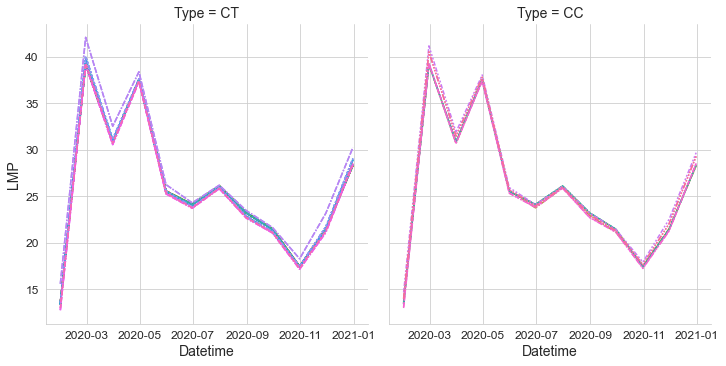

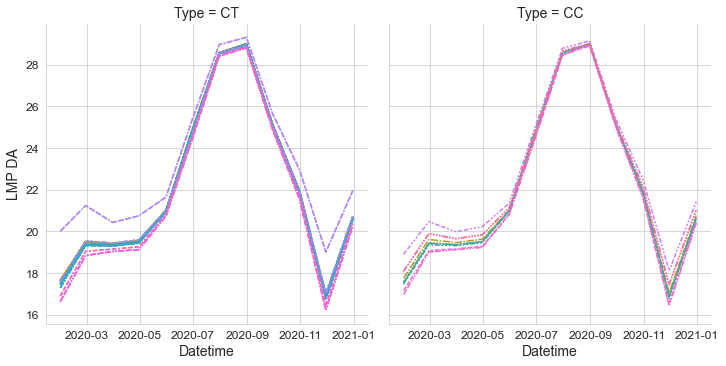

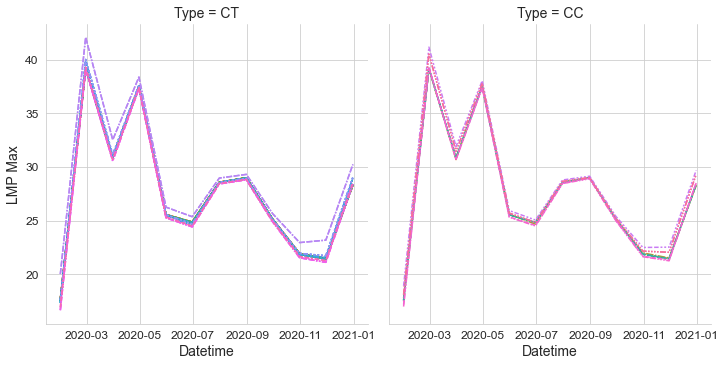

In [665]:
sns.relplot(
    data=gen_monthly, y="LMP", x="Datetime", hue="Generator", style='Bus',
    col="Type", kind="line", legend=False
)
sns.relplot(
    data=gen_monthly, y="LMP DA", x="Datetime", hue="Generator", style='Bus',
    col="Type", kind="line", legend=False
)
sns.relplot(
    data=gen_monthly, y="LMP Max", x="Datetime", hue="Generator", style='Bus',
    col="Type", kind="line", legend=False
)

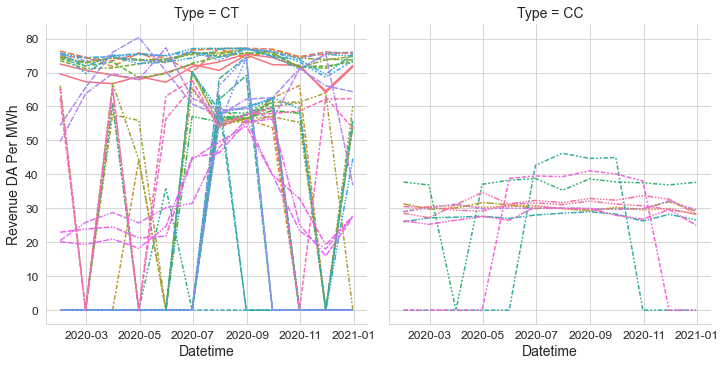

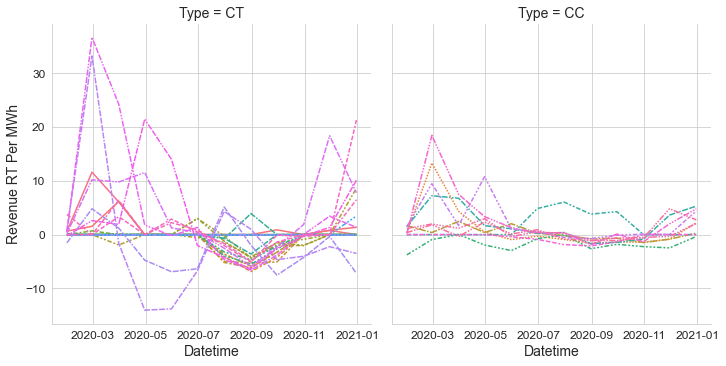

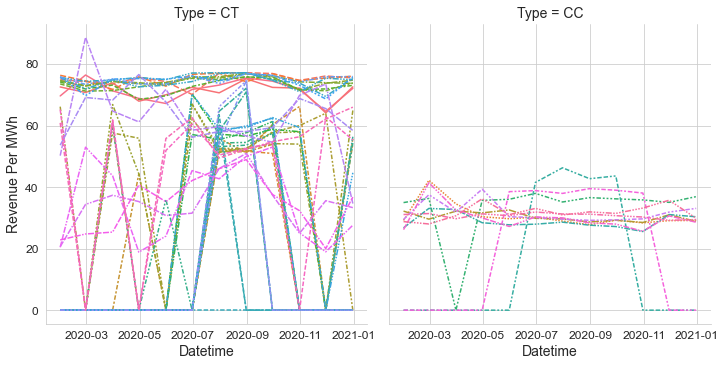

In [666]:
sns.relplot(
    data=gen_monthly, y="Revenue DA Per MWh", x="Datetime", hue="Generator", style='Bus',
    col="Type", kind="line", legend=False
)

sns.relplot(
    data=gen_monthly, y="Revenue RT Per MWh", x="Datetime", hue="Generator", style='Bus',
    col="Type", kind="line", legend=False
)

sns.relplot(
    data=gen_monthly, y="Revenue Per MWh", x="Datetime", hue="Generator", style='Bus',
    col="Type", kind="line", legend=False
)

### Get average shape and then translate up or down as average translation per generator

Text(0, 0.5, '$/MWh')

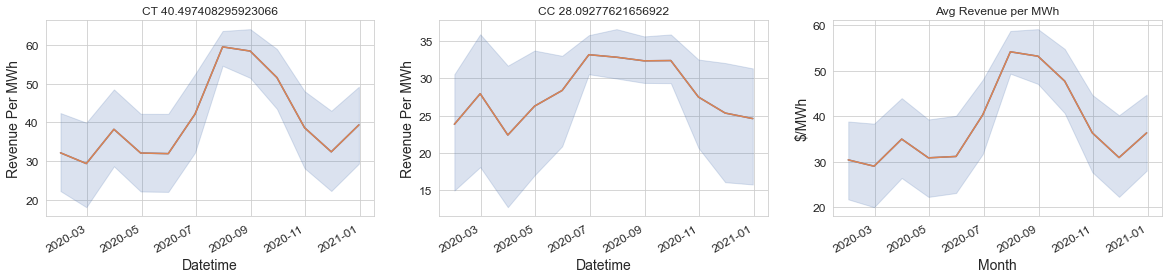

In [119]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4), sharex=True)
sns.lineplot(data=gen_monthly[gen_monthly['Type'] == "CT"], x='Datetime', y='Revenue Per MWh', ax=axs[0])
avg_revenue_per_mwh = gen_monthly[gen_monthly['Type'] == "CT"].groupby("Datetime").mean()['Revenue Per MWh']
avg_revenue_per_mwh.plot(title="CT "+str(avg_revenue_per_mwh.mean()), ax=axs[0])

sns.lineplot(data=gen_monthly[gen_monthly['Type'] == "CC"], x='Datetime', y='Revenue Per MWh', ax=axs[1])
avg_revenue_per_mwh = gen_monthly[gen_monthly['Type'] == "CC"].groupby("Datetime").mean()['Revenue Per MWh']
avg_revenue_per_mwh.plot(title="CC "+str(avg_revenue_per_mwh.mean()), ax=axs[1])

sns.lineplot(data=gen_monthly, x='Datetime', y='Revenue Per MWh', ax=axs[2])
avg_revenue_per_mwh = gen_monthly.groupby("Datetime").mean()['Revenue Per MWh']
avg_revenue_per_mwh.plot(title="Both "+str(avg_revenue_per_mwh.mean()), ax=axs[2])
avg_revenue_per_mwh.values

axs[2].set_xlabel("Month")
axs[2].set_title("Avg Revenue per MWh")
axs[2].set_ylabel("$/MWh")

In [680]:
fit_df_copy = fit_df.copy()

In [45]:
for gen in fit_df.Generator.unique():
    fit_df.loc[fit_df['Generator'] == gen, 'Avg Revenue Per MWh'] = gen_monthly[gen_monthly['Generator'] == gen]['Revenue Per MWh'].mean()
    fit_df.loc[fit_df['Generator'] == gen, 'Delta Avg Revenue Per MWh'] = gen_monthly[gen_monthly['Generator'] == gen]['Revenue Per MWh'].mean() - avg_revenue_per_mwh.mean()
    
fit_df = fit_df.dropna(axis=0)
fit_df

,Generator,Bus ID,Gen ID,Unit Group,Unit Type,Category,Fuel,MW Inj,MVAR Inj,V Setpoint p.u.,PMax MW,PMin MW,QMax MVAR,QMin MVAR,Min Down Time Hr,Min Up Time Hr,Ramp Rate MW/Min,Start Time Cold Hr,Start Time Warm Hr,Start Time Hot Hr,Start Heat Cold MBTU,Start Heat Warm MBTU,Start Heat Hot MBTU,Non Fuel Start Cost $,Non Fuel Shutdown Cost $,FOR,MTTF Hr,MTTR Hr,Scheduled Maint Weeks,Fuel Price $/MMBTU,Output_pct_0,Output_pct_1,Output_pct_2,Output_pct_3,HR_avg_0,HR_incr_1,HR_incr_2,HR_incr_3,VOM,Fuel Sulfur Content %,Emissions SO2 Lbs/MMBTU,Emissions NOX Lbs/MMBTU,Emissions Part Lbs/MMBTU,Emissions CO2 Lbs/MMBTU,Emissions CH4 Lbs/MMBTU,Emissions N2O Lbs/MMBTU,Emissions CO Lbs/MMBTU,Emissions VOCs Lbs/MMBTU,Damping Ratio,Inertia MJ/MW,Base MVA,Transformer X p.u.,Unit X p.u.,Pump Load MW,Storage Roundtrip Efficiency,L,L_abs,k,x_0,Avg Revenue Per MWh,Delta Avg Revenue Per MWh
8,107_CC_1,107,1,U355,CC,Gas CC,NG,355.00,49.51,1.0500,355.0,170,150,-25,4.5,8.0,4.14,2,1.00,0.50,7215.1,4536.1,3196.6,0,0,0.033,967,33,1.07,3.88722,0.478873,0.652582,0.826291,1.0,7222.0,5970.0,6892.0,7854.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,5.0,414.0,0.13,0.30,0,0,0.282116,8.773232e+05,6.217385,0.495930,30.733063,-7.232788
9,113_CT_1,113,1,U55,CT,Gas CT,NG,55.00,19.00,1.0347,55.0,22,19,-15,2.2,2.2,3.70,1,0.75,0.25,1457.4,1122.5,452.8,0,0,0.031,969,31,0.79,3.88722,0.400000,0.600000,0.800000,1.0,13125.0,6899.0,7602.0,7797.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,2.8,64.0,0.13,0.32,0,0,0.002528,1.217982e+03,37.484464,0.493910,17.523110,-20.442741
10,113_CT_2,113,2,U55,CT,Gas CT,NG,55.00,19.00,1.0347,55.0,22,19,-15,2.2,2.2,3.70,1,0.75,0.25,1457.4,1122.5,452.8,0,0,0.031,969,31,0.79,3.88722,0.400000,0.600000,0.800000,1.0,13125.0,6899.0,7602.0,7797.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,2.8,64.0,0.13,0.32,0,0,0.003546,1.708438e+03,49.131710,0.490665,19.457178,-18.508673
11,113_CT_3,113,3,U55,CT,Gas CT,NG,55.00,19.00,1.0347,55.0,22,19,-15,2.2,2.2,3.70,1,0.75,0.25,1457.4,1122.5,452.8,0,0,0.031,969,31,0.79,3.88722,0.400000,0.600000,0.800000,1.0,13125.0,6899.0,7602.0,7797.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,2.8,64.0,0.13,0.32,0,0,0.003493,1.683138e+03,33.163225,0.496954,21.269264,-16.696587
12,113_CT_4,113,4,U55,CT,Gas CT,NG,55.00,19.00,1.0347,55.0,22,19,-15,2.2,2.2,3.70,1,0.75,0.25,1457.4,1122.5,452.8,0,0,0.031,969,31,0.79,3.88722,0.400000,0.600000,0.800000,1.0,13125.0,6899.0,7602.0,7797.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,2.8,64.0,0.13,0.32,0,0,0.003141,1.513200e+03,52.205433,0.491635,13.707890,-24.257960
17,118_CC_1,118,1,U355,CC,Gas CC,NG,355.00,68.43,1.0500,355.0,170,150,-25,4.5,8.0,4.14,2,1.00,0.50,7215.1,4536.1,3196.6,0,0,0.033,967,33,1.07,3.88722,0.478873,0.652582,0.826291,1.0,7257.0,5808.0,7140.0,8351.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,5.0,414.0,0.13,0.30,0,0,0.287556,8.942411e+05,6.481355,0.490927,30.319669,-7.646182
20,123_CT_1,123,1,U55,CT,Gas CT,NG,55.00,0.62,1.0500,55.0,22,19,-15,2.2,2.2,3.70,1,0.75,0.25,1457.4,1122.5,452.8,0,0,0.031,969,31,0.79,3.88722,0.400000,0.600000,0.800000,1.0,12725.0,6757.0,7667.0,7998.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,2.8,64.0,0.13,0.32,0,0,0.011383,5.484142e+03,26.989268,0.494567,33.987187,-3.978664
21,123_CT_4,123,4,U55,CT,Gas CT,NG,55.00,0.62,1.0500,55.0,22,19,-15,2.2,2.2,3.70,1,0.75,0.25,1457.4,1122.5,452.8,0,0,0.031,969,31,0.79,3.88722,0.400000,0.600000,0.800000,1.0,12725.0,6757.0,7667.0,7998.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,2.8,64.0,0.13,0.32,0,0,0.011635,5.605632e+03,28.654250,0.493535,43.711690,5.745839
22,123_CT_5,123,5,U55,CT,Gas CT,NG,55.00,0.62,1.0500,55.0,22,19,-15,2.2,2.2,3.70,1,0.75,0.25,1457.4,1122.5,452.8,0,0,0.031,969,31,0.79,3.88722,0.400000,0.600000,0.800000,1.0,12725.0,6757.0,7667.0,7998.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,2.8,64.0,0.13,0.32,0,0,0.011426,5.505119e+03,27.237162,0.497452,33.124039,-4.841812
30,207_CT_1,207,1,U55,CT,Gas CT,NG,55.00,19.00,0.9699,55.0,22,19,-15,2.2,2.2

In [50]:
fit_df[['Avg Revenue Per MWh', 'Delta Avg Revenue Per MWh']]

,Avg Revenue Per MWh,Delta Avg Revenue Per MWh
8,30.733063,-7.232788
9,17.523110,-20.442741
10,19.457178,-18.508673
11,21.269264,-16.696587
12,13.707890,-24.257960
17,30.319669,-7.646182
20,33.987187,-3.978664
21,43.711690,5.745839
22,33.124039,-4.841812
30,25.060589,-12.905262


In [63]:
input_cols = [
      #  'MW Inj',
       'PMax MW',
       'HR_avg_0', 
      #  'HR_incr_1', 
      #  'HR_incr_2', 
      #  'HR_incr_3'
       ]
 
X = fit_df[input_cols].to_numpy()
y = fit_df['Delta Avg Revenue Per MWh'].to_numpy()

regtree = DecisionTreeRegressor(random_state=1)
regtree.fit(X, y)

poly = PolynomialFeatures(degree=1)
X_poly = poly.fit_transform(X)
regpoly = LinearRegression()
regpoly.fit(X_poly, y)

display(regtree.score(X, y), regpoly.score(X_poly,y))
display(sorted(list(zip(regpoly.coef_, poly.get_feature_names_out(input_cols))), key=lambda r: -r[0])[0:10])
display(regpoly.intercept_)

0.9697314633997483

0.2832666198289183

[(0.0, '1'),
 (-0.003476846235133585, 'HR_avg_0'),
 (-0.06604273277637121, 'PMax MW')]

40.84795433809603

In [60]:
poly.transform([[200, 11616]])

array([[1.0000e+00, 2.0000e+02, 1.1616e+04]])

In [61]:
regpoly.predict(poly.transform([[200, 11616]]))

array([-12.74763808])

<AxesSubplot:xlabel='HR_incr_2', ylabel='Delta Avg Revenue Per MWh'>

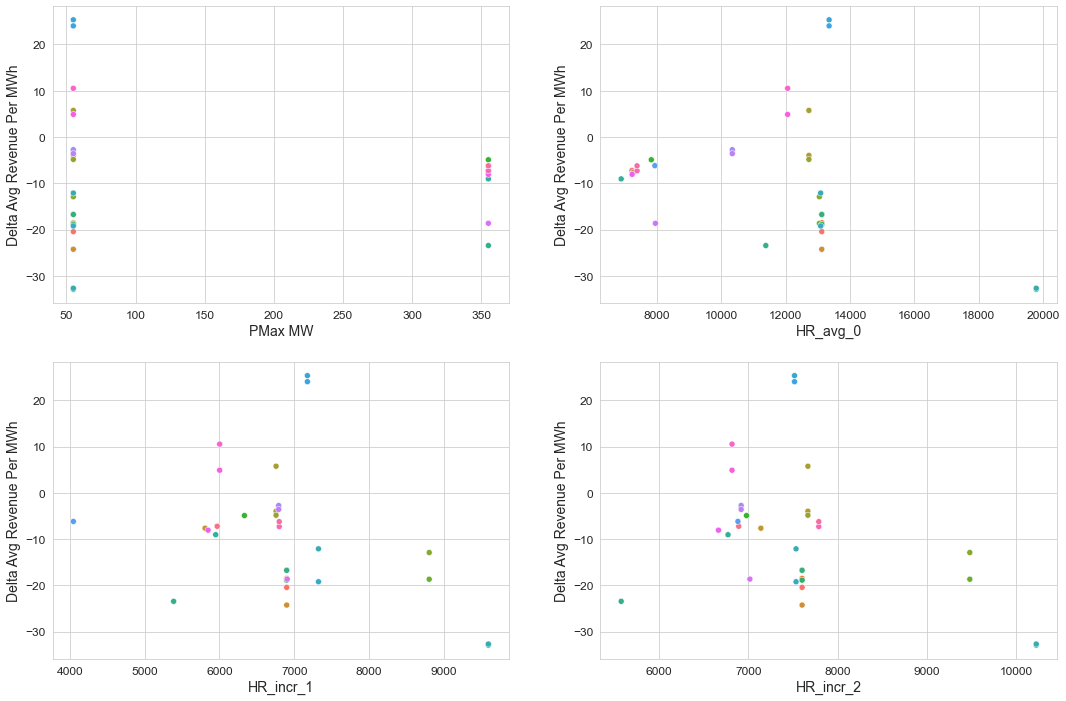

In [107]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
sns.scatterplot(ax=ax[0, 0],
    data=fit_df, y="Delta Avg Revenue Per MWh", x="PMax MW", hue="Generator", legend=False
)
sns.scatterplot(ax=ax[0, 1],
    data=fit_df, y="Delta Avg Revenue Per MWh", x="HR_avg_0", hue="Generator", legend=False
)
sns.scatterplot(ax=ax[1, 0],
    data=fit_df, y="Delta Avg Revenue Per MWh", x="HR_incr_1", hue="Generator", legend=False
)
sns.scatterplot(ax=ax[1, 1],
    data=fit_df, y="Delta Avg Revenue Per MWh", x="HR_incr_2", hue="Generator", legend=False
)

In [476]:
gen_df[gen_df['Generator'] == gen].resample("1M").sum()

,Output,Output DA,Curtailment,Unit Market Revenue,Unit Uplift Payment,Dispatch,Dispatch DA,Headroom,Unit Cost,CF,CF Max
Datetime,,,,,,,,,,,
2020-01-31,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-29,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-31,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-04-30,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-05-31,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-06-30,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-07-31,0.0,0.0,0.0,57888.071763,0.0,704.000000,789.033237,671.000000,62114.354848,0.001461,0.001706
2020-08-31,0.0,0.0,0.0,33453.906393,0.0,374.885941,484.000000,461.114059,36100.853870,0.000778,0.001005
2020-09-30,0.0,0.0,0.0,11148.364975,0.0,143.000000,165.000000,154.000000,12694.844204,0.000297,0.000342


### Fit NN

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [149]:
bid_df.columns

Index(['Generator', 'Bus ID', 'Gen ID', 'Unit Group', 'Unit Type', 'Category',
       'Fuel', 'MW Inj', 'MVAR Inj', 'V Setpoint p.u.', 'PMax MW', 'PMin MW',
       'QMax MVAR', 'QMin MVAR', 'Min Down Time Hr', 'Min Up Time Hr',
       'Ramp Rate MW/Min', 'Start Time Cold Hr', 'Start Time Warm Hr',
       'Start Time Hot Hr', 'Start Heat Cold MBTU', 'Start Heat Warm MBTU',
       'Start Heat Hot MBTU', 'Non Fuel Start Cost $',
       'Non Fuel Shutdown Cost $', 'FOR', 'MTTF Hr', 'MTTR Hr',
       'Scheduled Maint Weeks', 'Fuel Price $/MMBTU', 'Output_pct_0',
       'Output_pct_1', 'Output_pct_2', 'Output_pct_3', 'Output_pct_4',
       'HR_avg_0', 'HR_incr_1', 'HR_incr_2', 'HR_incr_3', 'HR_incr_4', 'VOM',
       'Fuel Sulfur Content %', 'Emissions SO2 Lbs/MMBTU',
       'Emissions NOX Lbs/MMBTU', 'Emissions Part Lbs/MMBTU',
       'Emissions CO2 Lbs/MMBTU', 'Emissions CH4 Lbs/MMBTU',
       'Emissions N2O Lbs/MMBTU', 'Emissions CO Lbs/MMBTU',
       'Emissions VOCs Lbs/MMBTU', 'Damping R

In [185]:
# Min Up Time Hr as state of charge required?
column_names = ['PMax MW', 'HR_avg_0', "Min Up Time Hr"]
column_names = ['PMax MW', 'PMin MW',
       'QMax MVAR', 'QMin MVAR', 'Min Down Time Hr', 'Min Up Time Hr',
       'Ramp Rate MW/Min', 'Start Time Cold Hr', 'Start Time Warm Hr',
       'Start Time Hot Hr', 'Start Heat Cold MBTU', 'Start Heat Warm MBTU',
       'Start Heat Hot MBTU', 'Output_pct_0',
       'Output_pct_1', 'Output_pct_2', 'Output_pct_3', 'Output_pct_4',
       'HR_avg_0', 'HR_incr_1', 'HR_incr_2', 'HR_incr_3', 'HR_incr_4', ]
column_names = ['PMax MW']
train_features = ng_df.copy()
train_features["Month"] = train_features.set_index("Datetime").index.month

for c in column_names:
    train_features[c] = -1
for gen in train_features['Generator'].unique():
    bid = bid_df[bid_df['Generator'] == gen]
    # for c in column_names:
        # train_features.loc[(ng_df['Generator'] == gen), c] = bid[c].unique()[0]

train_features = train_features.drop(columns=["Datetime", 'Generator', "Unit Market Revenue", 'Unit Uplift Payment', "Dispatch", 'Dispatch DA', 'Headroom', 'Unit Cost', 'Type'])
train_features = train_features.dropna(axis=1)

In [186]:
train_labels = train_features.pop('CF')
display(train_features)
display(train_labels)

,Month,PMax MW
0,1,-1
1,2,-1
2,3,-1
3,4,-1
4,5,-1
...,...,...
439,8,-1
440,9,-1
441,10,-1
442,11,-1


0      0.010369
1      0.024052
2      0.038023
3      0.053251
4      0.072451
         ...   
439    0.129194
440    0.149249
441    0.157799
442    0.164010
443    0.174411
Name: CF, Length: 444, dtype: float64

In [208]:
input_layer = layers.Input(train_features.shape[1:])

normalizer = layers.Normalization(input_shape=train_features.shape[1:], axis=None)
normalizer.adapt(train_features)
normalizer = normalizer(input_layer)

branch_a = layers.Dense(1, activation='sigmoid')(normalizer)
output_a = layers.Dense(1)(branch_a)

output_b = layers.Dense(1)(normalizer) # This will be one of my outputs, so I want a linear activation

final_output = layers.Add()([output_a, output_b])
model = tf.keras.Model(input_layer, final_output)

def my_loss_fn(y_true, y_pred):
    # squared_difference = tf.square(y_true - y_pred)
    loss = abs(y_true - y_pred)
    # return tf.reduce_mean(squared_difference, axis=-1) 
    return tf.reduce_mean(loss, axis=-1) 

model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
display(model.summary())

history = model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=50)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 normalization_53 (Normalizatio  (None, 2)           3           ['input_47[0][0]']               
 n)                                                                                               
                                                                                                  
 dense_129 (Dense)              (None, 1)            3           ['normalization_53[0][0]']       
                                                                                                  
 dense_130 (Dense)              (None, 1)            2           ['dense_129[0][0]']       

None

,loss,val_loss,epoch
45,0.053592,0.054197,45
46,0.047738,0.056285,46
47,0.042240,0.049898,47
48,0.037479,0.053934,48
49,0.033097,0.059562,49


In [209]:
display(train_features[:12])
display(train_labels[:12])
model.predict(train_features[:12])

,Month,PMax MW
0,1,-1
1,2,-1
2,3,-1
3,4,-1
4,5,-1
5,6,-1
6,7,-1
7,8,-1
8,9,-1
9,10,-1


0     0.010369
1     0.024052
2     0.038023
3     0.053251
4     0.072451
5     0.098337
6     0.140826
7     0.185158
8     0.214329
9     0.233772
10    0.243825
11    0.265779
Name: CF, dtype: float64

1/1 [==============================] - 0s 90ms/step


array([[-0.01751921],
       [-0.01246639],
       [-0.00794455],
       [-0.00394365],
       [-0.00045025],
       [ 0.00255284],
       [ 0.00508645],
       [ 0.00717527],
       [ 0.00884759],
       [ 0.01013532],
       [ 0.01107407],
       [ 0.01170236]], dtype=float32)

In [198]:
# temp list as a container for each layer formulas
formula_list = []
# counter of hidden layers
f_n = 1
#
for i in range(len(model.layers)):
    # get ith Keras layer's weights and biases
    layer = model.layers[i]
    W = layer.get_weights()
    print(W)

[]
[array([[-0.22545655],
       [-0.05729615]], dtype=float32), array([-0.09575251], dtype=float32)]
[array([[ 0.88948953],
       [-1.3107144 ]], dtype=float32), array([-0.09999999], dtype=float32)]
[]


In [6]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv("/Users/dguittet/Projects/Dispatches/dispatches/auto-mpg.data", names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [10]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [11]:
dataset = dataset.dropna()
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


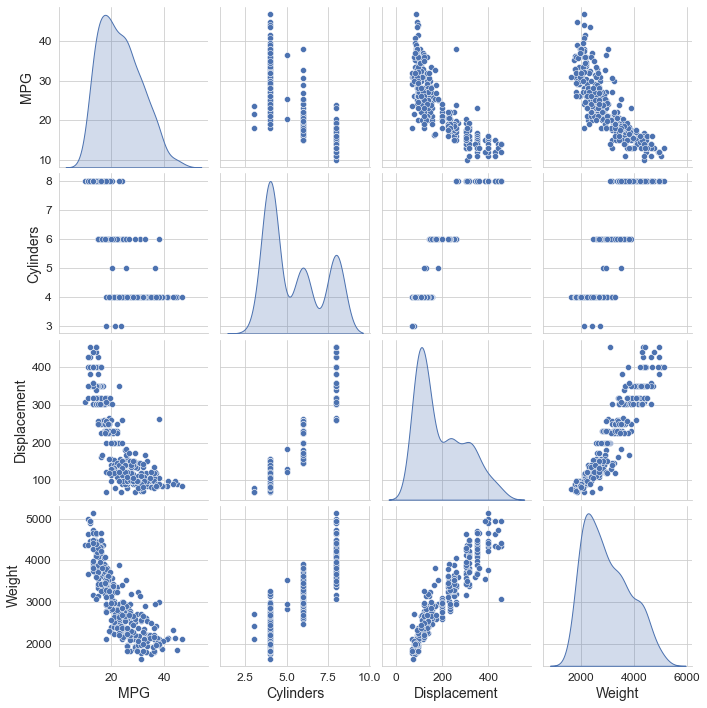

In [14]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [136]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

train_dataset.describe().transpose()[['mean', 'std']]
train_features.shape[1:]

(9,)

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
display(train_features)
print(normalizer.mean.numpy())

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,4,83.0,61.0,2003.0,19.0,74,0,1,0


[[5.47770691e+00 1.95318497e+02 1.04869446e+02 2.99025171e+03
  1.55592356e+01 7.58980942e+01 1.78343967e-01 1.97452217e-01
  6.24203861e-01]]


In [21]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [38]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [61]:
normalizer = layers.Normalization(input_shape=[9,], axis=None)
normalizer.adapt(train_features)
dnn_model = build_and_compile_model(normalizer)
display(dnn_model.summary())
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_15 (Normaliza  (None, 9)                3         
 tion)                                                           
                                                                 
 dense_52 (Dense)            (None, 64)                640       
                                                                 
 dense_53 (Dense)            (None, 64)                4160      
                                                                 
 dense_54 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,868
Trainable params: 4,865
Non-trainable params: 3
_________________________________________________________________


None

,loss,val_loss,epoch
95,3.057238,2.954131,95
96,3.023371,2.955534,96
97,3.023872,2.949449,97
98,3.017787,2.955465,98
99,3.030964,2.952008,99


In [64]:
input_layer = layers.Input(train_features.shape[1:])

normalizer = layers.Normalization(input_shape=[9,], axis=None)
normalizer.adapt(train_features)
normalizer = normalizer(input_layer)

branch_a = layers.Dense(64, activation='relu')(normalizer)
branch_a = layers.Dense(64, activation='relu')(branch_a)
output_a = layers.Dense(1)(branch_a) # This will be one of my outputs, so I want a linear activation

branch_b = layers.Dense(64, activation='relu')(normalizer)
branch_b = layers.Dense(64, activation='relu')(branch_a)
output_b = layers.Dense(1)(branch_a) # This will be one of my outputs, so I want a linear activation

final_output = layers.Concatenate()([output_a, output_b])
model = tf.keras.Model(input_layer, final_output)
model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
display(model.summary())

history = model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 9)]          0           []                               
                                                                                                  
 normalization_18 (Normalizatio  (None, 9)           3           ['input_18[0][0]']               
 n)                                                                                               
                                                                                                  
 dense_61 (Dense)               (None, 64)           640         ['normalization_18[0][0]']       
                                                                                                  
 dense_62 (Dense)               (None, 64)           4160        ['dense_61[0][0]']        

None

,loss,val_loss,epoch
95,3.014404,2.953662,95
96,3.027788,2.938610,96
97,3.028945,2.941897,97
98,3.020626,2.945016,98
99,3.028117,2.939891,99


In [146]:
input_layer = layers.Input(train_features.shape[1:])

normalizer = layers.Normalization(input_shape=[9,], axis=None)
normalizer.adapt(train_features)
normalizer = normalizer(input_layer)

output_a = layers.Dense(1, activation='sigmoid')(normalizer)

output_b = layers.Dense(1)(normalizer) # This will be one of my outputs, so I want a linear activation

final_output = layers.Add()([output_a, output_b])
model = tf.keras.Model(input_layer, final_output)

def my_loss_fn(y_true, y_pred):
    # squared_difference = tf.square(y_true - y_pred)
    loss = abs(y_true - y_pred)
    # return tf.reduce_mean(squared_difference, axis=-1) 
    return tf.reduce_mean(loss, axis=-1) 

model.compile(loss=my_loss_fn,
                optimizer=tf.keras.optimizers.Adam(0.001))
display(model.summary())

history = model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 4)]          0           []                               
                                                                                                  
 normalization_30 (Normalizatio  (None, 4)           3           ['input_29[0][0]']               
 n)                                                                                               
                                                                                                  
 dense_89 (Dense)               (None, 1)            5           ['normalization_30[0][0]']       
                                                                                                  
 dense_90 (Dense)               (None, 1)            5           ['normalization_30[0][0]']

None

,loss,val_loss,epoch
95,0.031278,0.051358,95
96,0.031799,0.053655,96
97,0.031395,0.052847,97
98,0.031502,0.050458,98
99,0.031958,0.053075,99
